![ecg_filter_diagram](./img/ecg_filter_diagram.png)

In [1]:
from typing import List
import numpy as np
import pandas as pd
import padasip as pa # adaptive filter package
import matplotlib.pyplot as plt
import scipy as sp

from lms import lms_filter, LmsResult

np.random.seed(42069) # always use the same random seed to make results comparable

In [2]:
# read ecg.dat into a numpy array
ecg = np.loadtxt('./data/ecg.dat')
n_samples = ecg.size

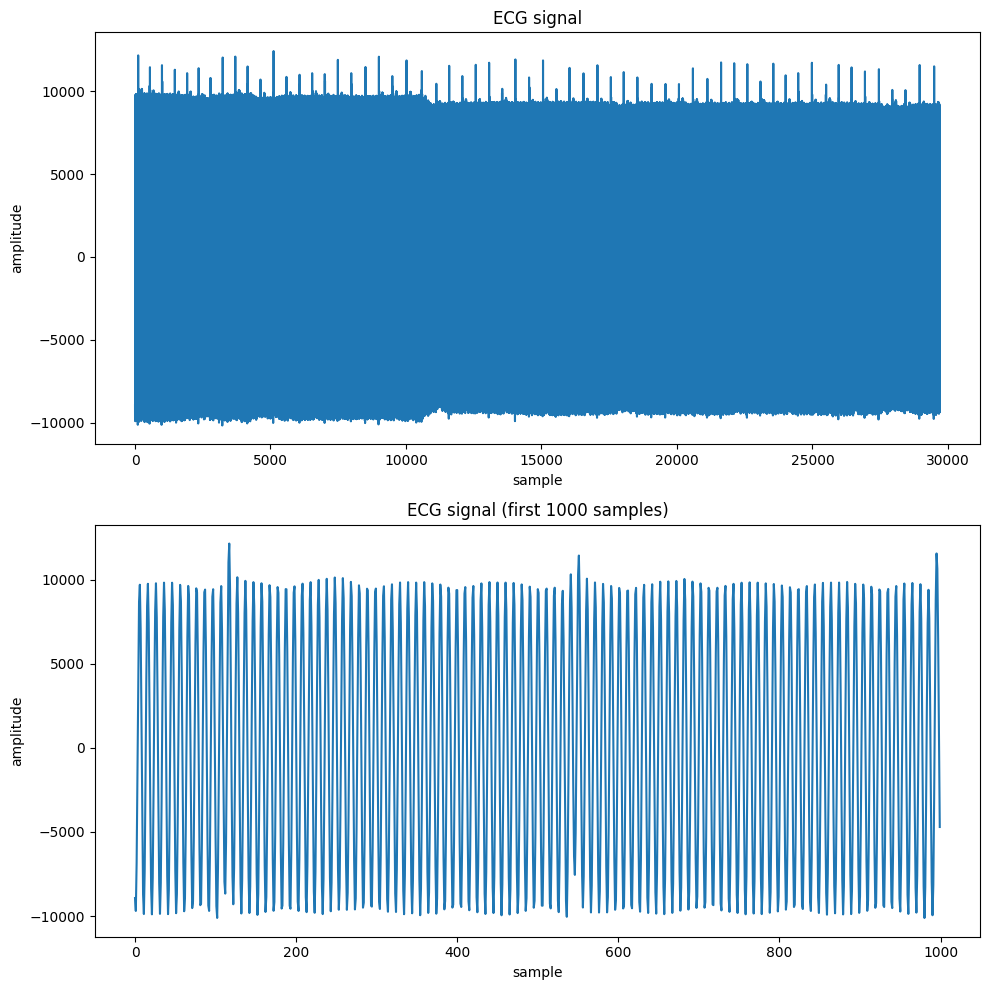

In [3]:
# plot ecg signal twice, once with the original signal and once with the first 1000 samples
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(ecg)
ax[0].set_title('ECG signal')
ax[0].set_xlabel('sample')
ax[0].set_ylabel('amplitude')
ax[1].plot(ecg[:1000])
ax[1].set_title('ECG signal (first 1000 samples)')
ax[1].set_xlabel('sample')
ax[1].set_ylabel('amplitude')
plt.tight_layout()
plt.show()

Power line frequency: 49.56 Hz


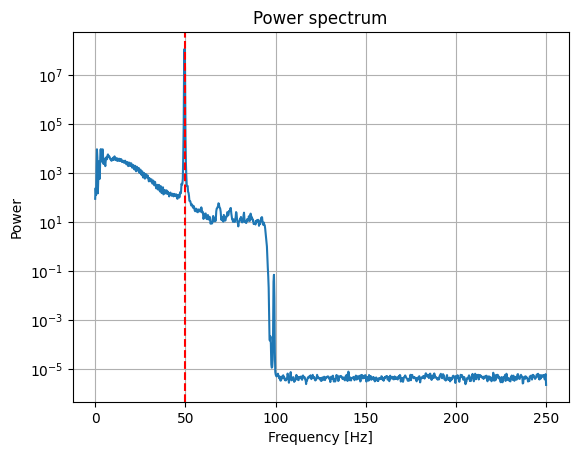

In [4]:
# find power line frequency (50 Hz)
Fs = 500 # sampling frequency
f, pxx = sp.signal.welch(ecg, Fs, nperseg=2048) # nperseg is the number of samples per segment i.e. the length of the window

max_pxx_idx: int = np.argmax(pxx)
powerline_freq: float = f[max_pxx_idx]
print(f'Power line frequency: {powerline_freq:.2f} Hz')

# plot power spectrum
plt.figure()
plt.plot(f, pxx)
plt.title('Power spectrum')
plt.xlabel('Frequency [Hz]')
plt.yscale('log') # more meaningful scale
plt.grid()
plt.ylabel('Power')
plt.axvline(x=powerline_freq, color='red', linestyle='--') # mark power line frequency
plt.savefig('./img/ecg_power_spectrum.png')
plt.show()

## 2  How many filter coeffcients are needed in the adaptive filter?

We have **1** frequency (50 Hz) that we want to affect, so we need **2** taps. <br>
With 1 tap we can only affect the gain of the signal, as we only have a scalar in H(z) <br>
With 2 taps we can affect both the gain and phase of the signal, as H(z) = a + bz^-1

In [5]:
ntaps = 2

## 3  Implement an LMS filter which removes the ECG signal from a generated sinusoid at the power line frequency.

In [6]:
# input signal is cos(2*pi*50*t)

# we want x to correlate with the noise in the ecg signal
x = np.cos(2 * np.pi * powerline_freq / Fs * np.arange(n_samples))

# TODO: compute misadjustment rate for lms filter

## 4  Select an appropriate value for the step-size μ.

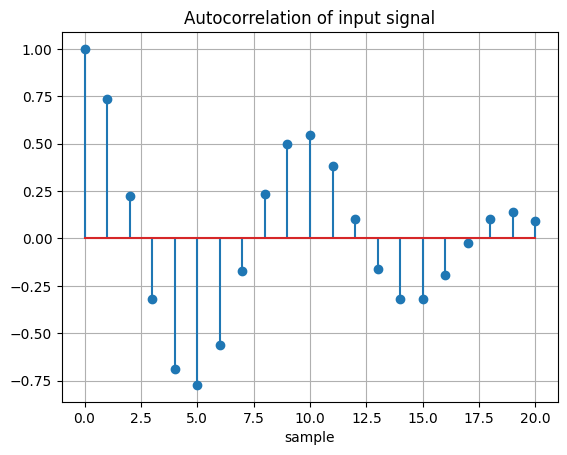

In [7]:
lags = 21

rx = sp.signal.correlate(x[:lags], x[:lags], mode='full')
rx = rx[(rx.size//2):] # take only the positive lags
rx /= rx[0] # normalize

# toepliz matrix
Rxx = sp.linalg.toeplitz(rx[(rx.size // 2):]) # take only the positive lags
# see equ. 6.73 for why we slice [:ntaps, :ntaps]
Rxx = sp.linalg.toeplitz(rx[(rx.size // 2):])[:ntaps, :ntaps] # take only the positive lags

# plot autocorrelation of input signal
plt.figure()
plt.stem(rx)
plt.title('Autocorrelation of input signal')
plt.grid()
plt.xlabel('sample')
plt.show()

![lms-stability-condition](./screenshots/stability-condition-for-lms.png)

In [8]:
trR = np.trace(Rxx)

upper_limit_for_learning_rate_with_lms = 1 / (3 * trR)
upper_limit_for_learning_rate_with_lms

print(f'0 < mu < {upper_limit_for_learning_rate_with_lms:.2f}')

0 < mu < 0.31


In [9]:
mu = 0.3 # step size between 0 and 1 / (3 * trR)

lms_result: LmsResult = lms_filter(x, ecg, mu, ntaps)
y = lms_result.y
err = lms_result.err
w = lms_result.w

##  5 Examine the error-signal e(k) by plotting it and comparing it with the original noisy ECG-signal.

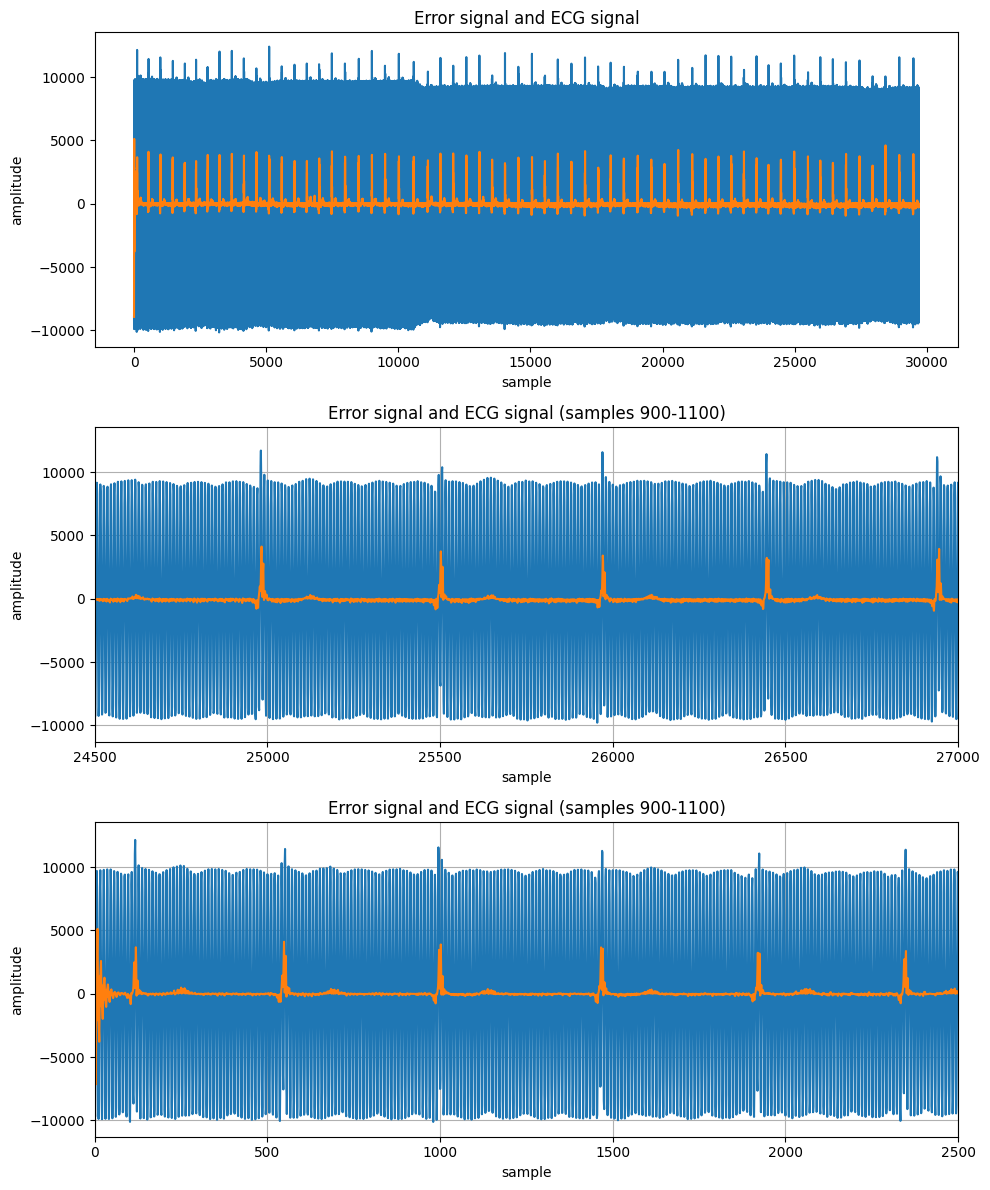

In [10]:
# plot error signal and ecg signal, fist with all samples and then with the first 1000 samples
_, ax = plt.subplots(3, 1, figsize=(10, 12))
ax[0].plot(ecg)
ax[0].plot(err)
ax[0].set_title('Error signal and ECG signal')
ax[0].set_xlabel('sample')
ax[0].set_ylabel('amplitude')

ax[1].plot(ecg)
ax[1].plot(err)
ax[1].set_title('Error signal and ECG signal (samples 900-1100)')
ax[1].set_xlabel('sample')
ax[1].set_xlim(24500, 27000)
ax[1].grid()
ax[1].set_ylabel('amplitude')

ax[2].plot(ecg)
ax[2].plot(err)
ax[2].set_title('Error signal and ECG signal (samples 900-1100)')
ax[2].set_xlabel('sample')
ax[2].set_xlim(0, 2500)
ax[2].grid()
ax[2].set_ylabel('amplitude')

# ax[3].plot(ecg)
# ax[3].plot(err)
# ax[3].set_title('Error signal, ECG signal and filtered ECG signal (samples 900-1100)')
# ax[3].set_xlabel('sample')
# ax[3].set_xlim(24500, 25500)
# ax[3].grid()
# ax[3].set_ylabel('amplitude')

plt.tight_layout()
plt.show()

/tmp/ipykernel_947790/3524613480.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[1].scatter(w[:, 0], w[:, 1], cmap=viridis,s=1)


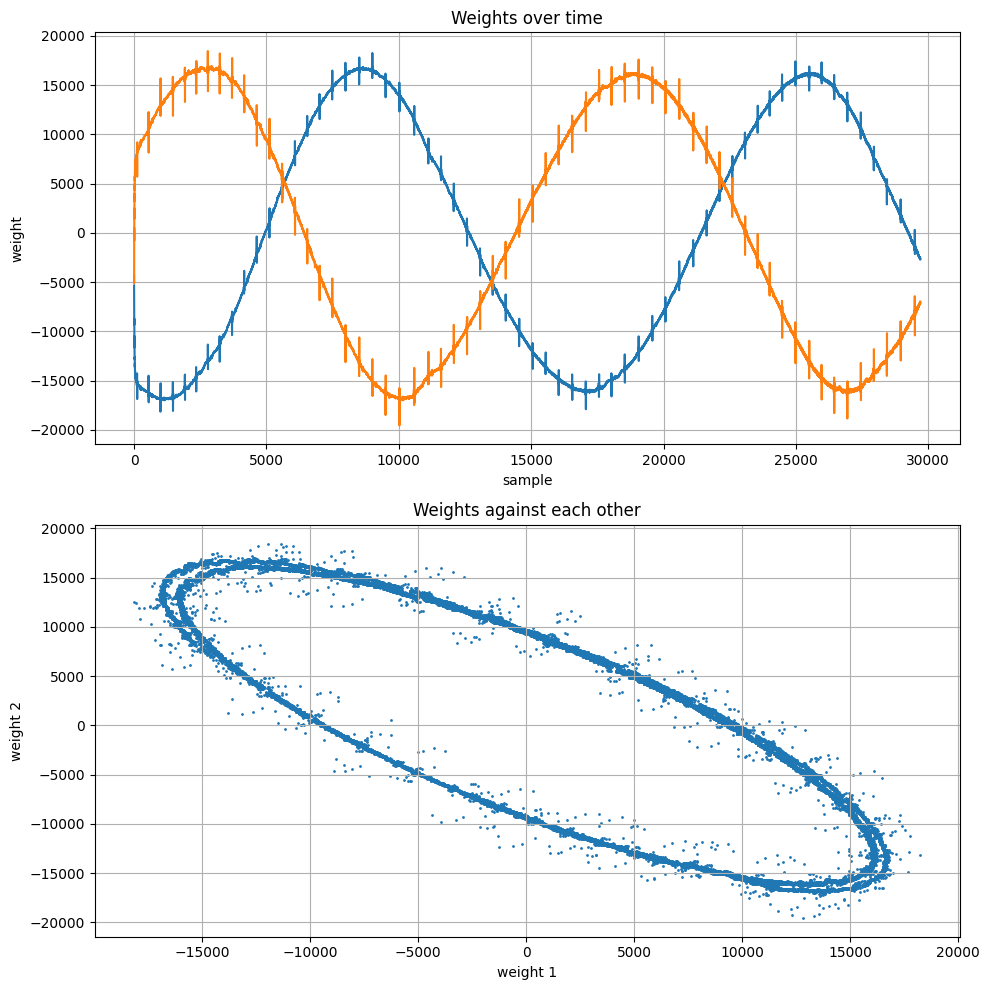

In [11]:
# plot weights over time and against each other
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(w)
ax[0].set_title('Weights over time')
ax[0].set_xlabel('sample')
ax[0].set_ylabel('weight')
ax[0].grid()
viridis = plt.get_cmap('viridis')
ax[1].scatter(w[:, 0], w[:, 1], cmap=viridis,s=1)
ax[1].set_title('Weights against each other')
ax[1].set_xlabel('weight 1')
ax[1].set_ylabel('weight 2')
ax[1].grid()
plt.tight_layout()
plt.show()

## 6  Adjust your parameters μ and the number of filter coefficients and see how good results you can acheive. If possible, estimate the improvement in signal-to-noise ratio.

In [12]:
# err is the signal of interest

# x is the noise in the ecg signal


def snr(signal, noise) -> float:
    """
    Compute the signal to noise ratio (SNR) of a signal.
    :param signal: the signal
    :param noise: the noise
    :return: the SNR in dB
    """
    return 10 * np.log10(np.sum(signal**2) / np.sum(noise**2))


granularity = 0.05

snrs = []

# test {2,3,4} x {0.0, granularity, ..., upper_limit_for_learning_rate_with_lms} combinations
for taps in [2,3,4]:
    for mu in np.arange(0.0 + granularity, upper_limit_for_learning_rate_with_lms, granularity): # [0.0, 0.05, ..., upper_limit_for_learning_rate_with_lms]
        lms_result: LmsResult = lms_filter(x, ecg, mu, taps)
        # y = lms_result.y
        print(f'err.shape {lms_result.err.shape}, ecg.shape {ecg.shape}')
        snrs.append((taps, mu, snr(lms_result.err, ecg[:-(taps - 1)] - lms_result.err)))

        # err = lms_result.err
        # mse = np.mean(err**2)
        # if mse < 0.0001:
        #     print(f'Converged with {taps} taps and mu = {mu:.2f}')
        #     break



err.shape (29700,), ecg.shape (29701,)
err.shape (29700,), ecg.shape (29701,)
err.shape (29700,), ecg.shape (29701,)
err.shape (29700,), ecg.shape (29701,)
err.shape (29700,), ecg.shape (29701,)
err.shape (29700,), ecg.shape (29701,)
err.shape (29699,), ecg.shape (29701,)
err.shape (29699,), ecg.shape (29701,)
err.shape (29699,), ecg.shape (29701,)
err.shape (29699,), ecg.shape (29701,)
err.shape (29699,), ecg.shape (29701,)
err.shape (29699,), ecg.shape (29701,)
err.shape (29698,), ecg.shape (29701,)
err.shape (29698,), ecg.shape (29701,)
err.shape (29698,), ecg.shape (29701,)
err.shape (29698,), ecg.shape (29701,)
err.shape (29698,), ecg.shape (29701,)
err.shape (29698,), ecg.shape (29701,)


In [13]:
snrs_sorted = sorted(snrs, key=lambda x: x[2], reverse=True)
best = snrs_sorted[0]
worst = snrs_sorted[-1]

df = pd.DataFrame(snrs_sorted, columns=['taps', 'mu', 'snr'])

# print(snrs_sorted)

# print(f'Best: {best}')
# print(f'Worst: {worst}')

print(df)

# get the best combination
# best = max(snrs, key=lambda x: x[2])
# print(f'Best combinatsion: {best}')


    taps    mu        snr
0      4  0.30 -22.829070
1      4  0.25 -23.542070
2      2  0.05 -23.790086
3      4  0.20 -24.172010
4      4  0.15 -24.753699
5      3  0.30 -24.775406
6      3  0.25 -25.019996
7      2  0.10 -25.092490
8      3  0.20 -25.222697
9      4  0.10 -25.299651
10     3  0.15 -25.404864
11     2  0.15 -25.424091
12     3  0.05 -25.473898
13     3  0.10 -25.560514
14     2  0.20 -25.579607
15     2  0.25 -25.689677
16     4  0.05 -25.712823
17     2  0.30 -25.771520


Run with 4 taps and mu = 0.30


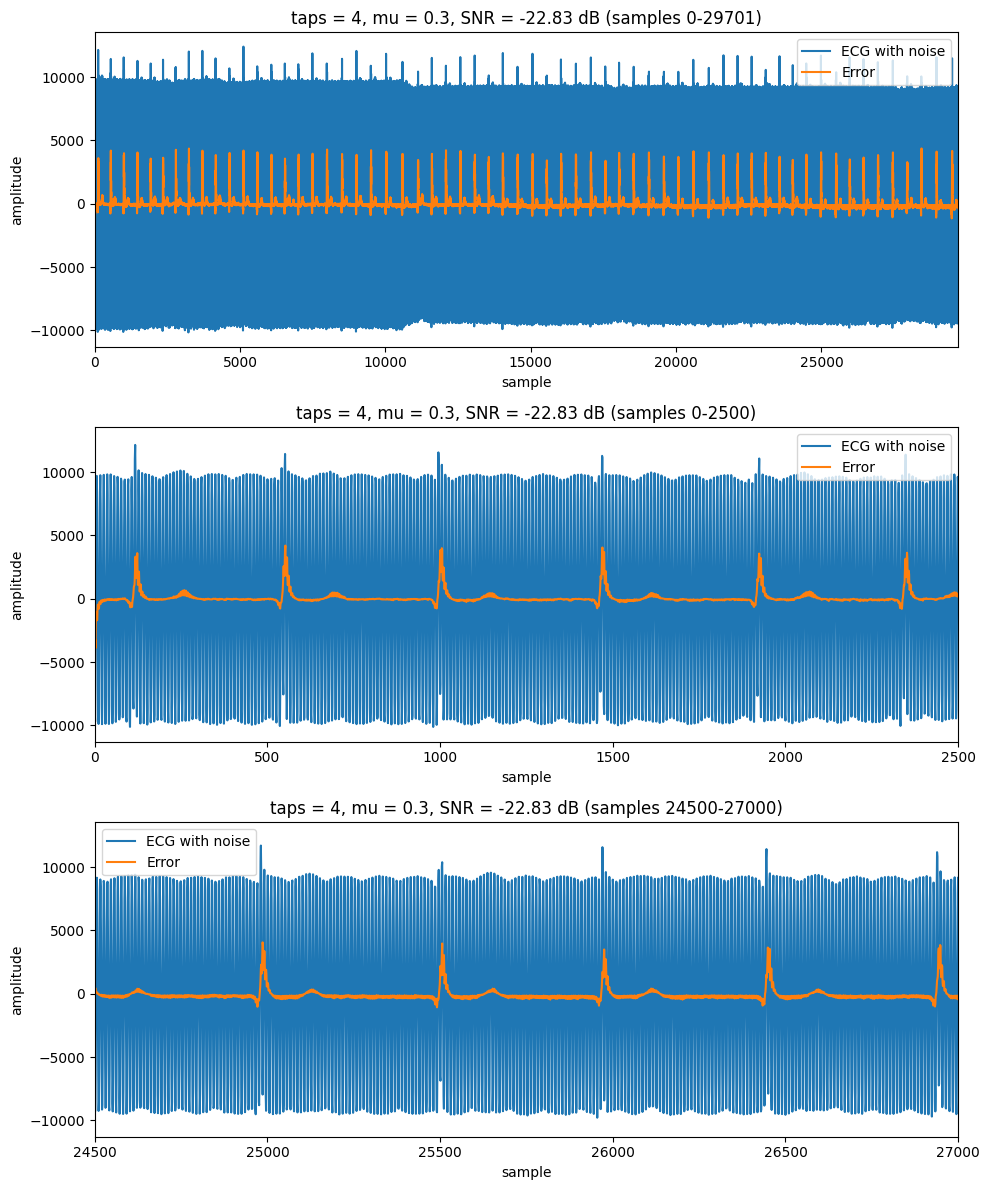

Run with 2 taps and mu = 0.30


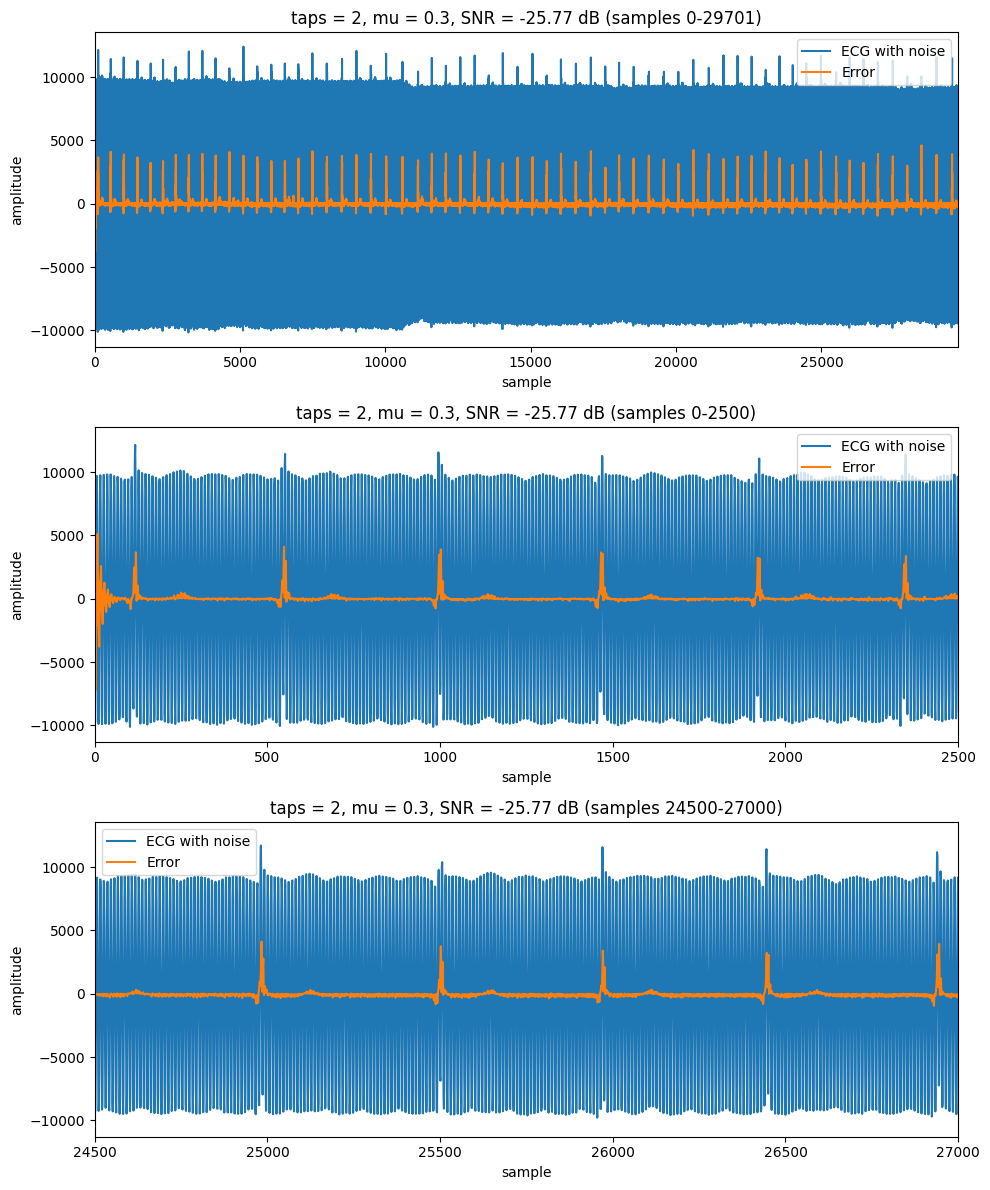

In [14]:
for run in {best, worst}:
    taps, mu, snr = run
    print(f'Run with {taps} taps and mu = {mu:.2f}')

    result = lms_filter(x, ecg, mu, taps)

    _, ax = plt.subplots(3, 1, figsize=(10, 12))

    for i, (xlim_min, xlim_max) in enumerate([(0, n_samples), (0, 2500), (24500, 27000)]):
        ax[i].plot(ecg)
        ax[i].plot(result.err)
        ax[i].set_title(f'taps = {taps}, mu = {mu}, SNR = {snr:.2f} dB (samples {xlim_min}-{xlim_max})')
        ax[i].set_xlabel('sample')
        ax[i].set_ylabel('amplitude')
        ax[i].set_xlim(xlim_min, xlim_max)
        ax[i].legend(['ECG with noise', 'Error'])

    plt.tight_layout()
    plt.show()

---

## Lets try with a NMLS filter instead

In [23]:
from importlib import reload
import nmls
reload(nmls) # reload the module to get the latest changes without restarting the kernel

psi = 0.1
mu = 0.1 # step size between 0 and 1 / (3 * trR)
n_taps = 2

nmls_result: nmls.Result = nmls.nlms(x, ecg, mu=mu, n_taps=n_taps, psi=psi)

x.shape (29701,), ecg.shape (29701,)


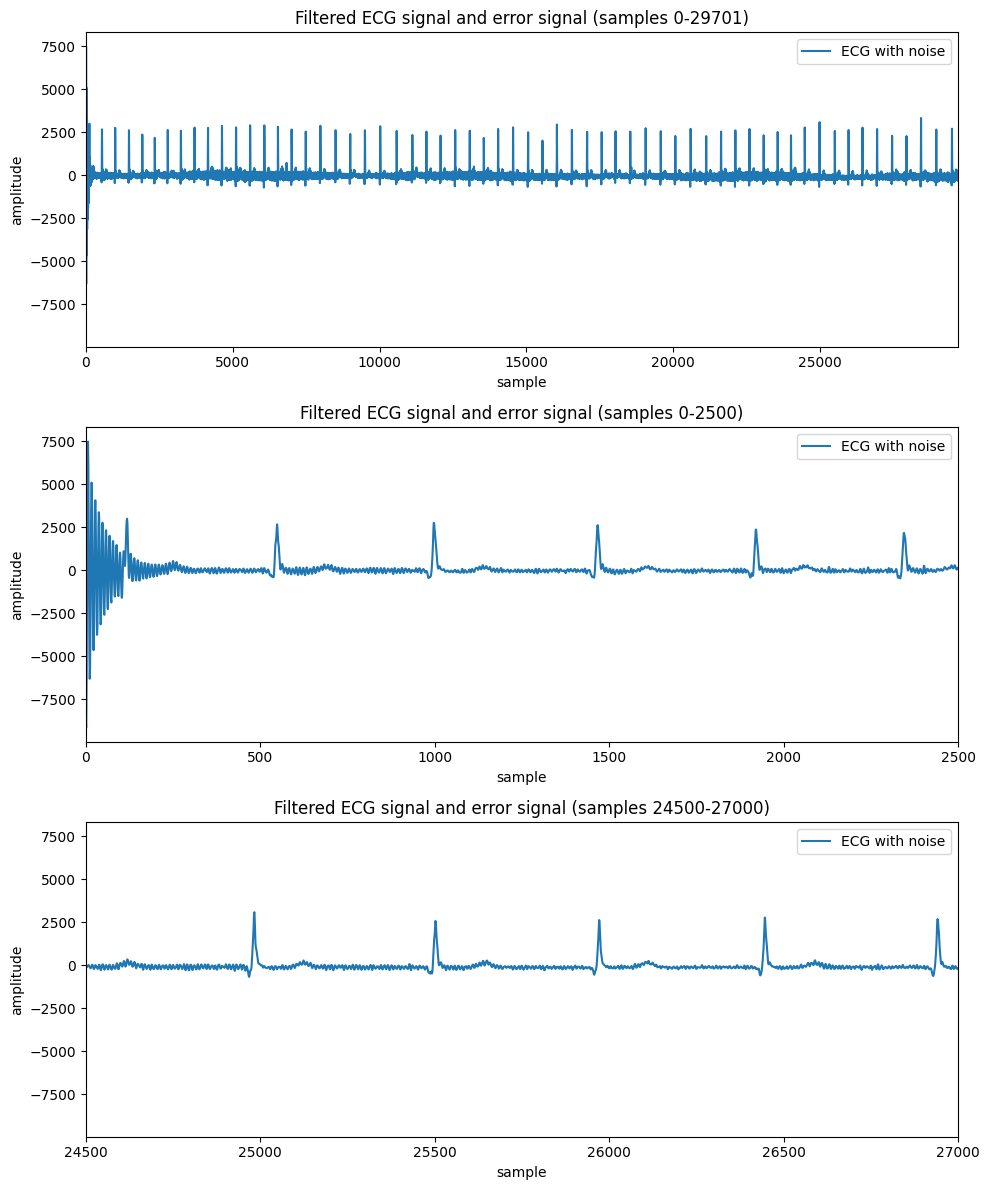

In [26]:
def plot_filtered_ecg_and_error_signal(ecg, error_signal):
    _, ax = plt.subplots(3, 1, figsize=(10, 12))

    for i, (xlim_min, xlim_max) in enumerate([(0, n_samples), (0, 2500), (24500, 27000)]):
        # ax[i].plot(ecg)
        # ax[i].plot(filtered_ecg)
        ax[i].plot(error_signal)
        ax[i].set_title(f'Filtered ECG signal and error signal (samples {xlim_min}-{xlim_max})')
        ax[i].set_xlabel('sample')
        ax[i].set_ylabel('amplitude')
        ax[i].set_xlim(xlim_min, xlim_max)
        ax[i].legend(['ECG with noise', 'Filtered ECG', 'Error'])

    plt.tight_layout()
    plt.show()

plot_filtered_ecg_and_error_signal(ecg, nmls_result.err)

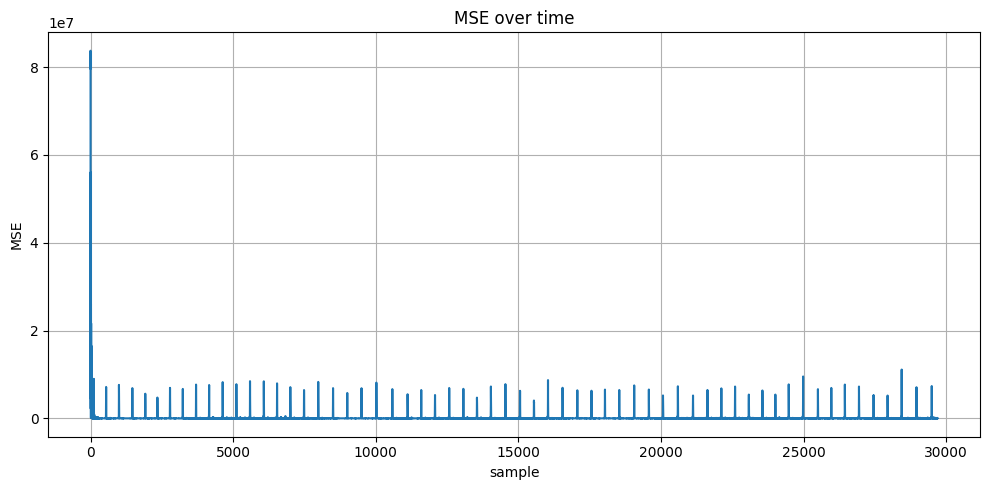

In [33]:
# plot mse over time
# TODO: is this correct?
mse = np.linalg.norm(nmls_result.y, axis=0)**2

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(nmls_result.mse)
ax.set_title('MSE over time')
ax.set_xlabel('sample')
ax.set_ylabel('MSE')
# ax.semilogy()
ax.grid()
plt.tight_layout()
plt.show()
